# Sec 1
Import libs used for Chinese topic modelling (jieba, gensim, and pyLDAvis)

In [219]:
# Chinese LDA for plot summaries
# Based on https://blog.csdn.net/weixin_39876856/article/details/111646357
# and https://www.cnblogs.com/zongfa/p/9556471.html
import jieba
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim import corpora, models, similarities

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

import logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import json
import urllib.request

Load film data from main JSON and initialise stop word list

NAME_STOPPING_SOURCE can be "Entities" (stop 615 names detected by NamedEntity Recognition), "Characters" (stop all 7150 fictional character names documented in The Catalogue of Chinese Art Films), or "None"

"Characters" might cause slowness but is the most accurate one.

In [220]:
NAME_STOPPING_SOURCE = "Characters"

with open("../metadata-all.json") as f:
    films = json.load(f)["films"]

print("Total number of films: ", len(films))

# Print all films in the dataset to check if it is loaded correctly
for [i, film] in enumerate(films):
	print("{} [{}] ({})".format(film["title"], film["translated"], film["year"]))
        
def stop_words():
	stopwords = []
	# Stop word for Chiense, list 1
	url_data = urllib.request.urlopen("https://raw.githubusercontent.com/stopwords-iso/stopwords-zh/master/stopwords-zh.txt")
	for line in url_data:
		#print(line.decode("utf-8"))
		word = line.decode("utf-8")
		if word not in stopwords:
			stopwords.append(word)

	# Stop word for Chiense, list 2
	url_data2 = urllib.request.urlopen("https://raw.githubusercontent.com/wanghaing/project-model-LDA/master/data/stop_word/stop_word%EF%BC%88utf8%EF%BC%89.txt")
	for line in url_data2:
		#print(line.decode("utf-8"))
		word = line.decode("utf-8")
		if word not in stopwords:
			stopwords.append(word)

	# An extra stop word list designed for old Chinese film plot summaries
	extra_list = open("./extra-stopwords.txt", "r", encoding="utf-8")
	for line in extra_list:
		if line not in stopwords:
			stopwords.append(line)
	
	if NAME_STOPPING_SOURCE == "Characters":
		entity_list = open("./ultimate_character_list(bianmu).txt", "r", encoding="utf-8")
		for line in entity_list:
			if line not in stopwords:
				stopwords.append(line)
	elif NAME_STOPPING_SOURCE == "Entities":
		# A list of entity names generated from the film metadata with Baidi API
		# Adding this list may decrease the readability of extracted topics
		entity_list = open("./plot_entities.txt", "r", encoding="utf-8")
		for line in entity_list:
			if line not in stopwords:
				stopwords.append(line)

	stopwords = [x.strip() for x in stopwords]
	print("{} stop words loaded".format(len(stopwords)))
	return stopwords

def tokenize(text, stop_words):
	#Remove all spaces, {LINE_CUT}, {COMMA}, {QUOTE} symbols in the text
	text = text.replace(" ", "").replace("{LINE_CUT}", "").replace("{COMMA}", "").replace("{QUOTE}", "").replace("”", "").replace("\n", "").replace('“', "")

	segmented = jieba.cut(text.strip())
	output = ""
	for seg in segmented:
		# Add one segment only if it is not a stop word and longer than 1 character
		if seg not in stop_words and len(seg) > 1:
				output += seg + " "
	return output

stop_words = stop_words()

Total number of films:  732
桥 [The Bridge] (1949)
回到自己队伍来 [Return to Our Army] (1949)
光芒万丈 [Light Spreads Everywhere] (1949)
中华女儿 [Daughters of China] (1949)
白衣战士 [Fighter in White] (1949)
无形的战线 [The Invisible Front Line] (1949)
表 [The Watch (aka An Orphan on the Streets)] (1949)
二百五小传 [The Story of a Foolish Man (aka The Heroic Opera Performer)] (1949)
乌鸦与麻雀 [Crows and Sparrows] (1949)
三毛流浪记 [The Story of “Three Hair” the Vagrant] (1949)
赵一曼 [Zhao Yiman] (1950)
光荣人家 [Honorable Family] (1950)
卫国保家 [Protecting Home Through the Nation] (1950)
红旗歌 [Song of the Red Flag] (1950)
钢铁战士 [Steeled Fighters] (1950)
高歌猛进 [Aggressively Moving Forward] (1950)
刘胡兰 [Liu Hulan] (1950)
辽远的乡村 [A Remote Village] (1950)
内蒙人民的胜利 [Victory for the People of Inner Mongolia] (1950)
白毛女 [The White-Haired Girl] (1950)
人民的战士 [People’s Soldiers] (1950)
保卫胜利果实 [Guarding the Fruits of Victory] (1950)
在前进的道路上 [On the Progressive Road] (1950)
吕梁英雄 [Heros of Lvliang] (1950)
鬼神不灵 [Ghosts Don’t Exist] (1950)
民主青年进行曲 [Demo

# Sec 2
Setting the setting(s) in the cell below to adjust the results

In [221]:
# Whether all films or only features should be analysed
# (Disabling this option seems to result in higher coherence scores)
FEATURE_FILM_ONLY = False

# Whether to apply the topic model per word or per topic
# An attribute in LDA model
APPLY_PER_WORD_TOPIC = True

Tokenise the plot summaries and print all

In [222]:
results = []

i = 0

for film in films:
	if FEATURE_FILM_ONLY and film["filmType"] != "Feature":
		print("Skipping film {} as it is not a feature film".format(film["title"]))
		continue
	plot = film["plot"]
	str = tokenize(plot, stop_words)
	if str != "":
		results.append([i, str])
		i += 1

print("\nTotal number of film plots loaded: ", len(results))
results = [n[1].split(" ")[:-1] for n in results]


Total number of film plots loaded:  732


Initialise "The Bag of Words" and LDA based on the tokenised plot summaries

In [223]:
word_bag = corpora.Dictionary(results)
corpus = [word_bag.doc2bow(text) for text in results]

#print([[(word_bag[id], freq) for id, freq in cp] for cp in corpus[:1]])

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
										   id2word=word_bag,
                                           num_topics=40,
                                           per_word_topics=APPLY_PER_WORD_TOPIC)

#pprint(lda_model.print_topics(num_words=20))

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=results, dictionary=word_bag, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.62850606206814

Coherence Score:  0.45686879215053394


Filter topics
(Suggested TOPIC_RANGE=46; TOPIC_STEP=5)
(Or TOPIC＿RANGE＝21; TOPIC_STEP=2 for more compact results when FEATURE_FILM_ONLY is off)

In [224]:
TOPIC_RANGE = 21
TOPIC_STEP = 2
ITERATION = 800

coherence_values = []
perplexity_values = []
model_list = []
for num_topics in range(TOPIC_STEP, TOPIC_RANGE, TOPIC_STEP):
	model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=word_bag, num_topics=num_topics,
					 						per_word_topics=APPLY_PER_WORD_TOPIC,
											iterations=ITERATION, eval_every=None, eta='auto',
											chunksize=5000, passes=40)
	model_list.append(model)
	coherencemodel = CoherenceModel(model=model, texts=results, dictionary=word_bag, coherence='c_v')
	coherence_values.append(round(coherencemodel.get_coherence(), 3))
	perplexity_values.append(round(model.log_perplexity(corpus), 3))


# Sec 3
## Results Output #1 (Parallel):
Get the best range of topic numbers

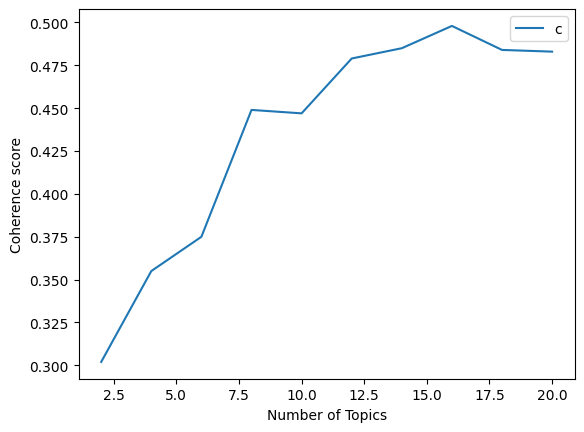

In [225]:
# Show graph
x = range(TOPIC_STEP, TOPIC_RANGE, TOPIC_STEP)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Sec 3
## Results Output #2 (Parallel):
Visualise attributes of optimal model

In [226]:
optimal_model = model_list[coherence_values.index(max(coherence_values))]
model_topics = optimal_model.show_topics(formatted=True)
pprint(optimal_model.print_topics(num_words=20))

print("\n")

[(0,
  '0.006*"游击队" + 0.006*"斗争" + 0.004*"革命" + 0.004*"情况" + 0.003*"合作社" + '
  '0.003*"群众" + 0.003*"计划" + 0.003*"地下" + 0.003*"带领" + 0.003*"被捕" + '
  '0.003*"党组织" + 0.003*"我军" + 0.003*"工作" + 0.003*"解放" + 0.003*"情报" + '
  '0.003*"日寇" + 0.003*"配合" + 0.002*"杀害" + 0.002*"破坏" + 0.002*"逮捕"'),
 (1,
  '0.005*"工作" + 0.003*"生产" + 0.003*"敌特" + 0.002*"文举" + 0.002*"群众" + 0.002*"农村" '
  '+ 0.002*"回到" + 0.002*"教育" + 0.002*"文秀" + 0.002*"公社" + 0.002*"情况" + '
  '0.002*"来到" + 0.002*"思想" + 0.002*"反对" + 0.002*"解放" + 0.002*"演出" + 0.002*"影响" '
  '+ 0.002*"金印" + 0.002*"少楼" + 0.002*"骑兵"'),
 (2,
  '0.004*"工作" + 0.003*"生活" + 0.003*"群众" + 0.003*"教育" + 0.003*"小组" + 0.003*"带领" '
  '+ 0.002*"广州" + 0.002*"生产" + 0.002*"万里" + 0.002*"支持" + 0.002*"英雄" + '
  '0.002*"山区" + 0.002*"离开" + 0.002*"批评" + 0.002*"思想" + 0.002*"找到" + 0.002*"赵头" '
  '+ 0.002*"斗争" + 0.002*"建设" + 0.002*"劳动"'),
 (3,
  '0.004*"工作" + 0.003*"两人" + 0.003*"鲤鱼" + 0.003*"乌力" + 0.003*"体育" + 0.003*"工地" '
  '+ 0.002*"丞相" + 0.002*"琼花" + 0.002*"桃叶妈" + 0.002*"教育" + 0

In [227]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, word_bag)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11     0.080147  0.044396       1        1  9.501018
1     -0.001696  0.008049       2        1  8.921173
0      0.150684  0.026236       3        1  7.597049
8      0.040316 -0.113112       4        1  7.588696
10     0.052089  0.027281       5        1  6.938237
15    -0.023264  0.107123       6        1  6.902023
2     -0.034298  0.033802       7        1  6.773391
12     0.059370 -0.030970       8        1  6.739116
13    -0.031374  0.039568       9        1  6.254687
7     -0.022164 -0.141792      10        1  5.954936
5     -0.103797 -0.021024      11        1  5.176609
14    -0.059871  0.019901      12        1  4.961958
4      0.032973 -0.031165      13        1  4.717898
9     -0.029329  0.042057      14        1  4.360176
6     -0.056946  0.011313      15        1  4.082543
3     -0.052839 -0.021664      16        1  3.530491, topic_info=      Term       Freq       Total Category  logprob  loglift
2334   合作社  54.000000   54.000000  Default  30.0000  30.0000
3938    陈士  14.000000   14.000000  Default  29.0000  29.0000
616     小组  32.000000   32.000000  Default  28.0000  28.0000
1717   游击队  78.000000   78.000000  Default  27.0000  27.0000
16548   宋江  12.000000   12.000000  Default  26.0000  26.0000
...    ...        ...         ...      ...      ...      ...
185     生产   3.664832  110.677306  Topic16  -6.1744  -0.0641
576     启发   2.546474   38.244367  Topic16  -6.5385   0.6344
394     斗争   2.546473   90.592127  Topic16  -6.5385  -0.2279
422     解放   2.546473   58.852946  Topic16  -6.5385   0.2034
903     侦察   2.546473   36.316742  Topic16  -6.5385   0.6862

[1024 rows x 6 columns], token_table=       Topic      Freq Term
term                       
679        1  0.644517   一再
679        3  0.161129   一再
679       16  0.161129   一再
3156      10  0.680142   一区
1017       1  0.111837   一场
...      ...       ...  ...
15185     12  0.705082  黑风口
3899       2  0.159913   龙江
3899       3  0.799566   龙江
7033       7  0.882251   龙袍
2456       3  0.857447  龙须沟

[2961 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 2, 1, 9, 11, 16, 3, 13, 14, 8, 6, 15, 5, 10, 7, 4])

In [228]:
def format_topics_sentences(ldamodel, corpus, texts):
    i = 0
    for item in corpus:
        f_key = films[i]["key"]
        doc_tops = ldamodel.get_document_topics(item, minimum_probability=0.0)
        new_list = sorted(doc_tops, key=lambda x: x[1], reverse=True)
        # Iterate the new list and add the topics with highest probabilities to the list
        j = 0
        #max_prob = new_list[0][1]
        
        #dominant_tops = []
        
        #while j < len(new_list):
        #    if new_list[j][1] >= max_prob:
        #            j += 1
        #            dominant_tops.append(new_list[j][0])
        #    else:
        #            break
        dominant_tops = [new_list[0][0]]

        #get_document_topics = [dominant_top]
        print("|||FILM:{}|||TOPICS:{}|||TEXT:{}".format(f_key, dominant_tops, texts[i]))
        i += 1
	

format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=results)

|||FILM:qiao|||TOPICS:[13]|||TEXT:['一九四七年', '东北', '铁路', '工厂', '支援', '解放战争', '接受', '抢修', '松花江', '铁桥', '看不到', '群众', '力量', '缺乏', '信心', '雇佣', '思想', '制造', '修复', '铁桥', '铆钉', '修复', '炼钢炉', '创造', '耐火砖', '白云石', '办法', '试验', '成功', '克服', '一系列', '困难', '制出', '修复', '铁桥', '铆钉', '赶修', '铁桥', '铁路', '工厂', '响应', '上级', '号召', '修桥', '工作', '江水', '解冻', '大桥', '修复']
|||FILM:hui dao zi ji dui wu lai|||TOPICS:[15]|||TEXT:['解放战争', '时期', '蒋军', '蒋军', '抢掠', '蒋军', '毒打', '围攻', '吴城时', '宣传教育', '深受感动', '前往', '城里', '说服', '一道', '鼓动', '被迫', '当兵', '蒋军', '投诚', '蒋军', '联合', '抓起', '欺压', '蒋军', '投诚']
|||FILM:guang mang wan zhang|||TOPICS:[10]|||TEXT:['东北', '发电厂', '蒋军', '逃窜', '破坏', '失业', '解放后', '人民政府', '修复', '发电厂', '响应号召', '党的领导', '团结', '群众', '工作', '发电机', '固定', '磁铁', '腐蚀', '提议', '办法', '克服', '技术人员', '股长', '和方', '负责', '鼓励', '工友', '合作', '克服困难', '修好', '发电机', '潜伏', '破坏', '气馁', '股长', '和方', '商量', '解决', '办法', '股长', '和方', '很受', '感动', '一道', '发电机', '修复', '保证', '全市', '供电']
|||FILM:zhong hua nv er|||TOPICS:[0]|||TEXT:['一九三六年', '东北', '不堪', '忍受', '日寇

The cell below prints all topics in each document with confidence

In [229]:
def format_all_topics_sentences(ldamodel, corpus, texts):
    i = 0
    for item in corpus:
        f_key = films[i]["key"]
        doc_tops = ldamodel.get_document_topics(item, minimum_probability=0.0)
        new_list = sorted(doc_tops, key=lambda x: x[1], reverse=True)

        #get_document_topics = [dominant_top]
        print("|||FILM:{}|||TOPICS:{}|||TEXT:{}".format(f_key, new_list, texts[i]))
        i += 1
	

format_all_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=results)

|||FILM:qiao|||TOPICS:[(14, 0.9812429), (13, 0.0012504744), (10, 0.0012504742), (15, 0.0012504742), (9, 0.001250474), (11, 0.001250474), (0, 0.0012504739), (1, 0.0012504739), (2, 0.0012504739), (3, 0.0012504738), (8, 0.0012504738), (4, 0.0012504735), (5, 0.0012504735), (7, 0.0012504735), (6, 0.0012504734), (12, 0.0012504734)]|||TEXT:['一九四七年', '东北', '铁路', '工厂', '支援', '解放战争', '接受', '抢修', '松花江', '铁桥', '看不到', '群众', '力量', '缺乏', '信心', '雇佣', '思想', '制造', '修复', '铁桥', '铆钉', '修复', '炼钢炉', '创造', '耐火砖', '白云石', '办法', '试验', '成功', '克服', '一系列', '困难', '制出', '修复', '铁桥', '铆钉', '赶修', '铁桥', '铁路', '工厂', '响应', '上级', '号召', '修桥', '工作', '江水', '解冻', '大桥', '修复']
|||FILM:hui dao zi ji dui wu lai|||TOPICS:[(10, 0.9652648), (15, 0.0023156875), (12, 0.0023156833), (11, 0.002315683), (0, 0.0023156828), (1, 0.0023156828), (2, 0.0023156828), (4, 0.0023156828), (6, 0.0023156828), (8, 0.0023156828), (3, 0.0023156826), (13, 0.0023156826), (14, 0.0023156826), (5, 0.0023156824), (7, 0.0023156824), (9, 0.0023156824)]|||TEXT:['解

# Sec 4 (Optional)

Save the optimal model in this run

In [230]:
optimal_model.save("./models/lda_model.model")